# Exercise 3.1
### Generation of MNIST digits with a GAN

First we import the modules we need

In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [4]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

Implement your **generator** network as a fully connected neural network

Start out with a network that:
* takes as input 100 Normally distributed numbers
* has four hidden layers with 4096 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [5]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,784),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [6]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()       
        self.discriminator = nn.Sequential(
            nn.Linear(784,1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5),
            nn.Linear(512,256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5),
            nn.Linear(256,1),
#             nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.discriminator(x)
        return x

## DCGAN

In [7]:
class DCGAN_G(nn.Module):
    def __init__(self, input_features, output_features):
        super(DCGAN_G, self).__init__()
        self.fc = nn.Sequential(
            nn.ConvTranspose2d(input_features, 1024, 3, stride=2), # 1->3
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 512, 3, stride=2),# 3->7
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, 2, stride=2),# 7->14
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),# 14->28
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, output_features, 3, stride=1, padding = 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)
#         print(x.shape)
        x = self.fc(x)
#         x = x.view(x.size(0), 1, 28, 28)
        return x

class DCGAN_D(nn.Module):
    def __init__(self, output_features):
        super(DCGAN_D, self).__init__()   
        self.cnn0 = nn.Sequential(
            nn.Conv2d(1, 128, 3, stride = 2, padding = 1), # 28 -> 14
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5)
#             nn.BatchNorm2d(128),
        )
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(128,256,3, stride = 2, padding = 1), # 14-> 7
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5)
#             nn.BatchNorm2d(256)
        )
        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(256,512,7, stride = 1, padding = 0), # 7 -> 1
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5)
#             nn.BatchNorm2d(512)
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(512,output_features,1, stride = 1, padding = 0), # 1 -> 1
#             nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.cnn0(x)
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.discriminator(x)
        return x

## Loss Function Section

In [8]:
def vanilla_loss_d(dx, dz):    
    ## dx dz have passed sigmoid, range from 0 to 1
#     return -(torch.mean(torch.log(dx)) + torch.mean(torch.log(1-dz)))
    return torch.mean(-dx + torch.log(torch.exp(dx)+1)+torch.log(torch.exp(dz)+1))

def vanilla_loss_g(dz):
    ## dx dz have passed sigmoid, range from 0 to 1
#     return -torch.mean(torch.log(dz))
    return torch.mean(torch.log(torch.exp(-dz)+1))

In [9]:
def wgan_loss_d(dx, dz):
    return -(torch.mean(dx) - torch.mean(dz))

def lsgan_loss_d(dx, dz):
    b = 1
    return 0.5*torch.mean((dx - b)**2)+0.5*torch.mean((dz)**2)

def lsgan_loss_g(dz):
    c = 1
    return 0.5*torch.mean((dz-c)**2)

Output()

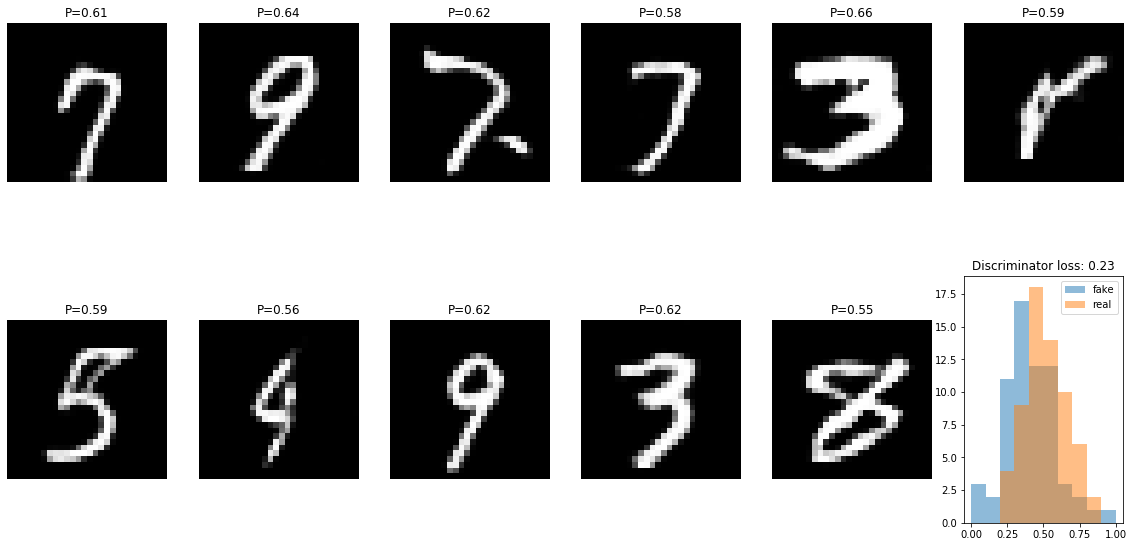

In [39]:
useDCGAN = True
if useDCGAN == True:
    #Initialize networks
    d = DCGAN_D(1).to(device)
    g = DCGAN_G(100,1).to(device)
else:
    #Initialize networks
    d = D().to(device)
    g = G().to(device)


losstype = 1
if losstype == 1:
    cost_d = lsgan_loss_d
    cost_g = lsgan_loss_g
elif losstype == 2:
    cost_d = vanilla_loss_d
    cost_g = vanilla_loss_g

#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)*2-1
        
        #Update Discriminator
        z = torch.randn(x.shape[0], 100).to(device)
        d.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g(z)
        d_loss=cost_d(d(x), d(xhat))
        
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z = torch.randn(batch_size, 100).cuda()
        g.zero_grad()
        xhat = g(z)
        g_loss = cost_g(d(xhat))
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
                P = torch.sigmoid(d(xhat))
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('P=%.2f' % P[k])
                    subplots[k].axis('off')

                H1 = d(g(torch.randn(batch_size, 100).to(device)))
                H2 = d(x)
               
                subplots[11].cla()
                subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
                subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
                subplots[11].legend()
                subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)
                

Did you get a model to generate nice images?
Consider these
# Additional tasks
* Implement another loss - **done**
* Convert your network to a DCGAN - **done**
* Generate images from FashionMNIST - **done**
* Convert your architecture into a cGAN - **done**
* Hard: Create a cGAN model to convert from SVHN to MNIST

In [40]:
print(np.log(0.2))

-1.6094379124341003


## FashionMNIST

### my initial implementation: hope it will work.

In [41]:
# download
batch_size = 64
fashion_trainset = datasets.FashionMNIST('./data', train=True, download=True, 
                                         transform=transforms.ToTensor())
fashion_train_loader = DataLoader(fashion_trainset, 
                                  batch_size=batch_size, 
                                  shuffle=True, num_workers=1)
fashion_testset = datasets.FashionMNIST('./data', train=False, download=True, 
                                        transform=transforms.ToTensor())
fashion_test_loader = DataLoader(fashion_trainset, 
                                 batch_size=batch_size, 
                                 shuffle=False, num_workers=1)


In [42]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The code will run on GPU. This is important so things run faster.


Output()

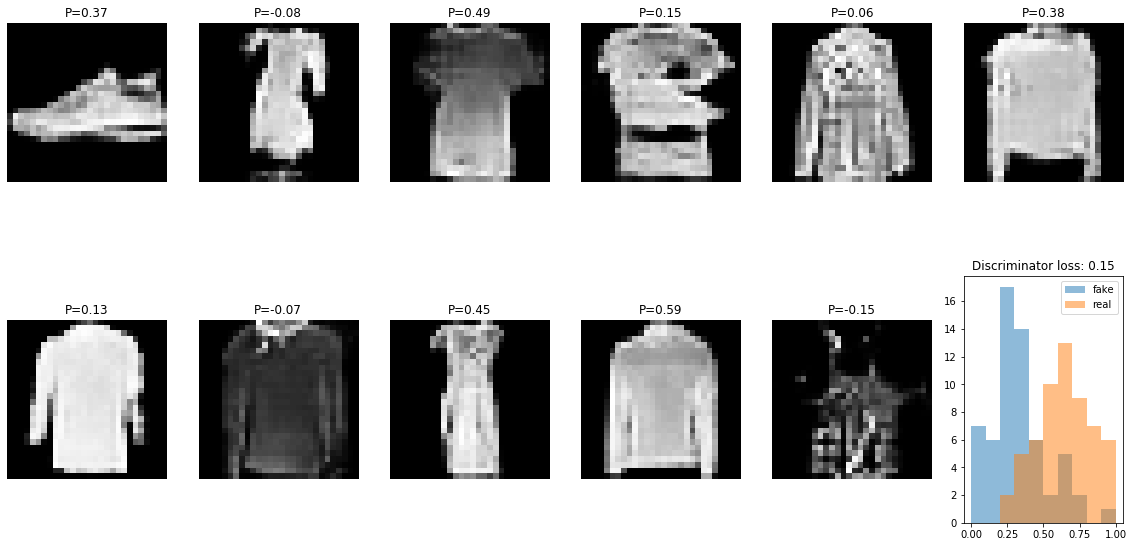

In [46]:
useDCGAN = True
if useDCGAN == True:
    #Initialize networks
    d = DCGAN_D(1).to(device)
    g = DCGAN_G(1000,1).to(device)
else:
    #Initialize networks
    d = D().to(device)
    g = G().to(device)
    

losstype = 1
if losstype == 1:
    cost_d = lsgan_loss_d
    cost_g = lsgan_loss_g
elif losstype == 2:
    cost_d = vanilla_loss_d
    cost_g = vanilla_loss_g

#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(fashion_train_loader), total=len(fashion_train_loader)):
        x = x.to(device)*2-1
        
        #Update Discriminator
        z = torch.randn(x.shape[0], 1000).to(device)
        d.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g(z)
        d_loss=cost_d(d(x), d(xhat))
        
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z = torch.randn(batch_size, 1000).cuda()
        g.zero_grad()
        xhat = g(z)
        g_loss = cost_g(d(xhat))
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
                P = (d(xhat))
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('P=%.2f' % P[k])
                    subplots[k].axis('off')

                H1 = d(g(torch.randn(batch_size, 1000).to(device)))
                H2 = d(x)
               
                subplots[11].cla()
                subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
                subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
                subplots[11].legend()
                subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)
                

## CGAN - implementation

In [10]:
loss = nn.BCELoss()
def cgan_loss_d(d_real, x_label, d_xhat, z_label):
    ## use soft-max
    d_real = torch.sigmoid(d_real)
    d_xhat = torch.sigmoid(d_xhat)
    return loss(d_real,x_label)+loss(d_xhat,z_label)
    

def cgan_loss_g(d_xhat, z_label):
    d_xhat = torch.sigmoid(d_xhat)
    return loss(d_xhat,z_label)



Output()

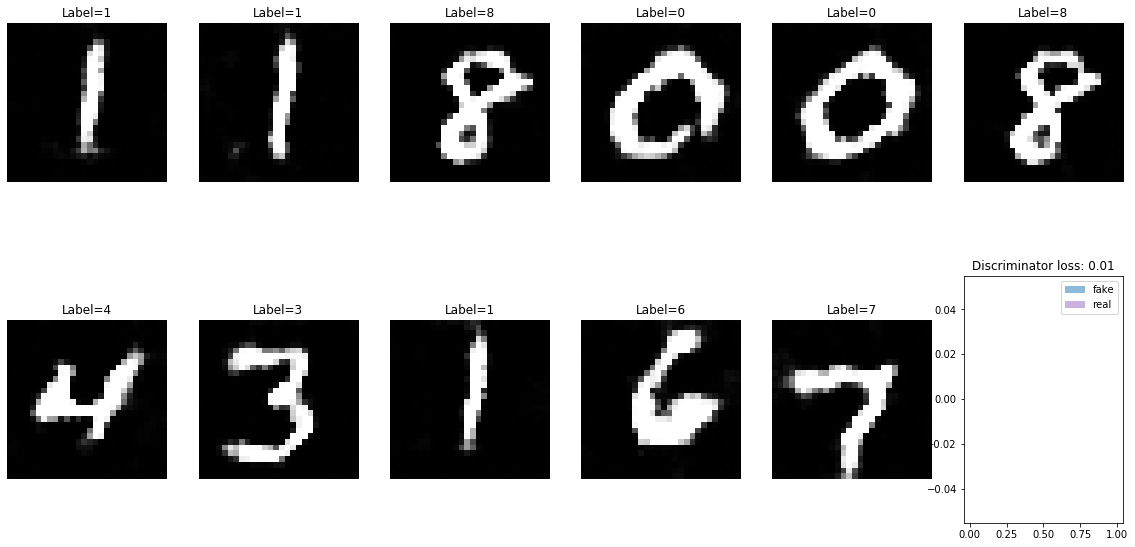

In [82]:
useDCGAN = True
if useDCGAN == True:
    #Initialize networks
    d = DCGAN_D(10).to(device)
    g = DCGAN_G(110,1).to(device)
else:
    #Initialize networks
    d = D().to(device)
    g = G().to(device)

#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        label_cpu = torch.zeros((x.shape[0],10))
        label_cpu[np.arange(x.shape[0]),target.numpy()] = 1
        x = x.to(device)*2-1
        x_label = label_cpu.to(device)
        d_real = d(x)
        
        #Update Discriminator
        z = torch.randn(x.shape[0], 100)
        z_label = torch.zeros((z.shape[0],10))
        z_combine = torch.cat((z,z_label),dim=1)
#         print(z_combine.shape)
        z_combine = z_combine.to(device)
        z_label = z_label.to(device)
        d.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g(z_combine)
        d_loss=cgan_loss_d(d_real, x_label, d(xhat), z_label)
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z = torch.randn(x.shape[0], 100)
        z = torch.cat((z,label_cpu),dim=1)
        z = z.to(device)
        g.zero_grad()
        xhat = g(z)
        g_loss = cgan_loss_g(d(xhat), x_label)
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
#                 P = torch.sigmoid(d(xhat))
#                 P = torch.max(P,dim=1)
#                 print(P.shape)
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('Label=%d' % target[k])
                    subplots[k].axis('off')

                zsample = torch.randn(batch_size, 100)
                zsample = torch.cat((zsample,label_cpu),dim=1)
                zsample = zsample.to(device)
                H1 = d(g(zsample))
                H2 = d(x)
                
                subplots[11].cla()
                subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
                subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
                subplots[11].legend()
                subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)
                

In [85]:
## save model
def save_model(model, filename):  #save model for later plot
    state = model.state_dict()
    x=state.copy()
    for key in x: 
        x[key] = x[key].clone().cpu()
    torch.save(x, filename)
save_model(g, './model/cgan_Generator.pkl')
save_model(d, './model/cgan_Discriminator.pkl')


In [10]:
def show(images,num_img):
    images = 255 * (0.5 * images + 0.5)
    images = images.astype(np.uint8)
    plt.figure(figsize=(4, 4))
    width = images.shape[2]
    gs = gridspec.GridSpec(1, num_img, wspace=0, hspace=0)
    print(images.shape)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(width, width), cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()
    plt.tight_layout()
    return width

def show_all(images_all,num_img):
    x=images_all[0]
    for i in range(1,len(images_all),1):
        x=np.concatenate((x,images_all[i]),0)
    print(x.shape)
    x = 255 * (0.5 * x + 0.5)
    x = x.astype(np.uint8)
    plt.figure(figsize=(9, 10))
    width = x.shape[2]
    gs = gridspec.GridSpec(10, num_img, wspace=0, hspace=0)
    for i, img in enumerate(x):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(width, width), cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()

In [ ]:
d.load_state_dict(torch.load('./model/cgan_Discriminator.pkl'))
g.load_state_dict(torch.load('./model/cgan_Generator.pkl'))
import matplotlib.gridspec as gridspec

lis=[]
batch_size = 16
for i in range(10):
    z = torch.randn((batch_size, 100))
    x = torch.zeros((batch_size,10))
    x[:,i]=1
    z = torch.cat((z, x),dim=1).to(device)
    gz = g(z)
    fake_image = gz.cpu().detach().numpy()
    print(fake_image.shape)
    lis.append(fake_image)
    output = d(gz)
    show(fake_image,batch_size)

show_all(lis,batch_size)
plt.show()

## SVHN to MNIST

In [11]:
import os.path
new_transform = transforms.Compose([transforms.Grayscale(),
                                    transforms.Resize(28),
                                    transforms.ToTensor()])
# download if necessary
if not os.path.isfile('./data/train_32x32.mat'):
    # use as digital training set
    svhn_train_set = datasets.SVHN('./data',split='train',download=True, 
                                   transform=new_transform)
else:
    svhn_train_set = datasets.SVHN('./data',split='train',download=True, 
                                   transform=new_transform)

Using downloaded and verified file: ./data/train_32x32.mat


73257
8


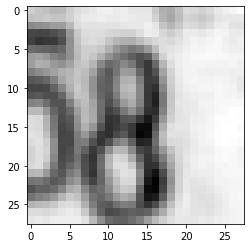

In [12]:
print(len(svhn_train_set))
for image, label in svhn_train_set:
    image = svhn_train_set[29][0].view(image.size(1),image.size(2))
#     print(image)
    plt.imshow(image.numpy(),cmap='gray')
    print(svhn_train_set[29][1])
    break

In [ ]:
useDCGAN = True
if useDCGAN == True:
    #Initialize networks
    d = DCGAN_D(10).to(device)
    g = DCGAN_G(28*28+10,1).to(device)
else:
    #Initialize networks
    d = D().to(device)
    g = G().to(device)

#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        label_cpu = torch.zeros((x.shape[0],10))
        label_cpu[np.arange(x.shape[0]),target.numpy()] = 1
        x = x.to(device)*2-1
        x_label = label_cpu.to(device)
        x_label = x_label.view(x_label.size(0),x_label.size(1),1,1)
        d_real = d(x)
        
        #Update Discriminator
        zid = torch.randint(0, len(svhn_train_set), (x.shape[0],))
        z = torch.zeros((x.shape[0],28*28))
        z_label = torch.zeros((x.shape[0],10))
        for i in range(len(zid)):
            img = svhn_train_set[zid[i]][0]*2-1
            z[i,:] = img.flatten()
#             lb_id = svhn_train_set[zid[i]][1] if svhn_train_set[zid[i]][1] < 10 else 0
#             z_label[i,lb_id] = 1
#         print(z_label)        
        z_combine = torch.cat((z,z_label),dim=1)
        z_combine = z_combine.to(device)
        
        z_label = z_label.view(z_label.size(0),z_label.size(1),1,1)
        z_label = z_label.to(device)
        d.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g(z_combine)
        d_loss=cgan_loss_d(d_real, x_label, d(xhat), z_label)
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z_label = torch.zeros((x.shape[0],10))
        
        for i in range(len(zid)):
            img = svhn_train_set[zid[i]][0]*2-1
            lb_id = svhn_train_set[zid[i]][1] if svhn_train_set[zid[i]][1] < 10 else 0
            z_label[i,lb_id] = 1
        
        z = torch.cat((z,z_label),dim=1)
        z = z.to(device)
        z_label = z_label.view(z_label.size(0),z_label.size(1),1,1)
        z_label = z_label.to(device)
        
        g.zero_grad()
        xhat = g(z)
        z_label = z_label.view(z_label.size(0),z_label.size(1),1,1)
        z_label = z_label.to(device)
        g_loss = cgan_loss_g(d(xhat), z_label)
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
                lbs = torch.argmax(z_label,dim=1)
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('Label=%d' % lbs[k])
                    subplots[k].axis('off')

#                 zsample = torch.randn(batch_size, 100)
#                 zsample = torch.cat((zsample,label_cpu),dim=1)
#                 zsample = zsample.to(device)
#                 H1 = d(g(zsample))
#                 H2 = d(x)
                
#                 subplots[11].cla()
#                 subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
#                 subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
#                 subplots[11].legend()
#                 subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)

Output()

In [32]:
a=torch.randint(1, 5, (3,4))
print(a)

tensor([[2, 3, 4, 3],
        [2, 1, 2, 4],
        [4, 1, 2, 4]])
